### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import pandas as pd

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

/Users/saman.tamkeen/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Test Rig for Environment 

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
print(Time_matrix.shape)
print(Time_matrix[0][0][23][1])

(5, 5, 24, 7)
0.0


#### Test env

In [3]:
driver_env = CabDriver(debug=True)

CabDriver initialized with following config {'action_space': [(1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (0, 0)], 'state_space_length': 840, 'state_size': 36, 'total_reward': 0, 'total_time_consumed': 0, 'state_init': (4, 4, 1)}


In [4]:
# Check Requests
actions = driver_env.requests(driver_env.state_init)

# select random action
action = random.choice(actions)
print('Random Action Selected : ', action)

# Check Rewards Earned and Next state for random Action
next_state, reward, is_terminal = driver_env.step(driver_env.state_init,action)
print('Reward Value : ',reward)
print('Next State Value : ',next_state)
print('Is terminal : ',is_terminal)

# Check Rewards Earned and Next state for Action - (0,0) - Driver didn't take any request.
next_state, reward, is_terminal = driver_env.step(driver_env.state_init,(0,0))
print('Reward Value : ',reward)
print('Next State Value : ',next_state)
print('Is terminal : ',is_terminal)

state_encode = driver_env.encode_state_v1(driver_env.state_init)

possible actions:  (4, 4, 1)  ->  [(3, 1), (5, 3), (4, 1), (2, 1), (0, 0), (1, 5)]
Random Action Selected :  (3, 1)
step:  {'state': (4, 4, 1), 'action': (3, 1), 'time_spent_for_pickup': 6, 'pickup_hour': 10, 'pickup_day': 1, 'time_spent_for_ride': 6}
Reward Value :  -6
Next State Value :  (1, 16, 1)
Is terminal :  False
step:  {'state': (4, 4, 1), 'action': (0, 0), 'time_spent_for_pickup': 5, 'pickup_hour': 9, 'pickup_day': 1, 'time_spent_for_ride': 0}
Reward Value :  -5
Next State Value :  (4, 5, 1)
Is terminal :  False
encode_state_v1:  (4, 4, 1)  ->  [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [13]:
episode_num = [0]
accu_rewards = [0]
total_time = [0]
total_steps = [0]
episodes_max = 100

driver_env=CabDriver()

for i in range(1,episodes_max+1):
    driver_env.reset()
    state = driver_env.state_init
    is_terminal = False
    steps = 0
    while not is_terminal:
        # random action selection
        actions = driver_env.requests(state)
        action = random.choice(actions)
        
        next_state, reward, is_terminal = driver_env.step(state, action)
        state = next_state
        steps = steps + 1
    
    tot_rewards, tot_time = driver_env.tracking_info()
    episode_num.append(i)
    accu_rewards.append(tot_rewards)
    total_time.append(tot_time)
    total_steps.append(steps)
    
episodes_vs_rewards=pd.DataFrame(data={'Accumulated_Rewards':accu_rewards,
                                      'Total_Time':total_time,
                                      'Episode_Number':episode_num,
                                      'Total_Steps':total_steps})

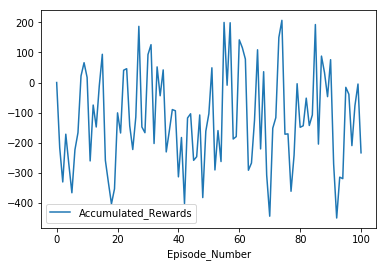

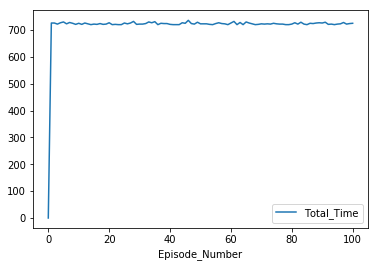

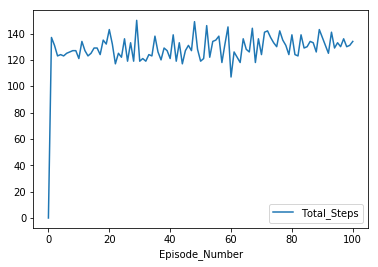

In [14]:
# Plot rewards vs Episodes
episodes_vs_rewards.plot(x='Episode_Number',y='Accumulated_Rewards')
episodes_vs_rewards.plot(x='Episode_Number',y='Total_Time')
episodes_vs_rewards.plot(x='Episode_Number',y='Total_Steps')

#### Tracking the state-action pairs for checking convergence


In [3]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
class DQNAgent:
    def __init__(self, state_size=None, action_size=None, discount_factor=0.95, learning_rate=0.01, 
                 epsilon_min=0.01, epsilon_max=1, epsilon_decay=0.99, batch_size=32, experience_buffer_size=2000,
                 debug=False, env=CabDriver()):
        # Define size of state and action
        if state_size is not None:
            self.state_size = state_size
        else:
            self.state_size = env.state_size

        if action_size is not None:
            self.action_size = action_size
        else:
            self.action_size = len(env.action_space)

        self.discount_factor = discount_factor
        self.learning_rate = learning_rate 
        self.epsilon_min = epsilon_min
        self.epsilon_max = episodes_max
        self.epsilon = epsilon_max
        self.epsilon_decay = epsilon_decay
        
        self.batch_size = batch_size        
        # create replay memory using deque
        self.memory = deque(maxlen=experience_buffer_size)
        
        self.debug = debug
        self.env = env
        
        if self.debug:
            print('DQNAgent initialized with following params: ', {
                'state_size':self.state_size,
                'action_size':self.action_size,
                'discount_factor':self.discount_factor,
                'learning_rate':self.learning_rate,
                'episodes_min':self.epsilon_min,
                'epsilon_max':self.epsilon_max,
                'epsilon':self.epsilon,
                'epsilon_decay':self.epsilon_decay,
                'batch_size':self.batch_size
            })

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):

        model = Sequential()

        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
#         model.add(BatchNormalization())
#         model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
#         model.add(Dropout(0.25))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        if self.debug:
            model.summary()

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        return model

    def get_action(self, state):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        """
        get action in a state according to an epsilon-greedy approach
        """

        if np.random.rand() <= self.epsilon_max:
            # random action selection
            actions = self.env.requests(state)
            action = random.choice(actions)
            if self.debug:
                print('Random action chosen: ', action)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            encoded_state = self.env.encode_state_v1(state)
            q_value = self.model.predict(encoded_state)
            action = self.env.action_space[np.argmax(q_value[0])]
            if self.debug:
                print('Predicted action chosen: ', action)

        return action

    def append_sample(self, state, action, reward, next_state, is_terminal):
        self.memory.append((state, action, reward, next_state, is_terminal))
        
    def decay_epsilon(self):
        # Decay in ε after we generate each sample from the environment
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
   
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """
        train the neural network on a minibatch. Input to the network is the states,
        output is the target q-value corresponding to each action.
        """
        if len(self.memory) >= self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            action, reward, is_terminal = [], [], []
            
            for i in range(self.batch_size):
                update_input[i] = self.env.encode_state_v1(mini_batch[i][0])
                action.append(mini_batch[i][1])
                reward.append(mini_batch[i][2])
                update_output[i] = self.env.encode_state_v1(mini_batch[i][3])
                is_terminal.append(mini_batch[i][4])
 
            # predict the target q-values from states s
            target = self.model.predict(update_input)

            # target for q-network
            target_qval = self.model.predict(update_output)

            # update the target values
            for i in range(self.batch_size):
                action_index = self.env.action_space.index(action[i])
                if is_terminal[i]:
                    target[i][action_index] = reward[i]
                else:
                    target[i][action_index] = reward[i] + self.discount_factor * (np.amax(target_qval[i]))

            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save(name)

### DQN block

In [28]:
def train_agent(episodes_to_run=1000, model_name='model.hd5', debug=False):
    env = CabDriver(debug=debug)

    #Call the DQN agent
    agent = DQNAgent(debug=debug)

    scores, episodes = [], []

    for episode in range(episodes_to_run):    
        is_terminal = False
        score = 0
        state = env.reset()

        print(env.tracking_info())

        while not is_terminal:
            # Write your code here
            # 1. Pick epsilon-greedy action from possible actions for the current state
            # 2. Evaluate your reward and next state
            # 3. Append the experience to the memory
            # 4. Train the model by calling function agent.train_model
            # 5. Keep a track of rewards, Q-values, loss

            # get action for the current state and go one step in environment
            action = agent.get_action(state)
            next_state, reward, is_terminal = env.step(state, action)
            agent.append_sample(state, action, reward, next_state, is_terminal)
            agent.decay_epsilon()
            agent.train_model()

            state = next_state

        total_rewards, total_time = env.tracking_info()
        scores.append(tot_rewards)
        episodes.append(episode)

        print("episode:", episode, "  score:", tot_rewards, "  memory length:", len(agent.memory), "  epsilon:", agent.epsilon)

        if episode % 50 == 0:
            agent.save(model_name)

In [25]:
train_agent(episodes_to_run=1, debug=True)

CabDriver initialized with following config {'action_space': [(1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (0, 0)], 'state_space_length': 840, 'state_size': 36, 'total_reward': 0, 'total_time_consumed': 0, 'state_init': (2, 14, 4)}
DQNAgent initialized with following params:  {'state_size': 36, 'action_size': 21, 'discount_factor': 0.95, 'learning_rate': 0.01, 'episodes_min': 0.01, 'epsilon_max': 100, 'epsilon': 1, 'epsilon_decay': 0.99, 'batch_size': 32}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 32)                1184      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_21 (Dense)             

Random action chosen:  (3, 2)
step:  {'state': (1, 8, 4), 'action': (3, 2), 'time_spent_for_pickup': 5, 'pickup_hour': 13, 'pickup_day': 4, 'time_spent_for_ride': 1}
Random action chosen:  (5, 4)
step:  {'state': (2, 14, 4), 'action': (5, 4), 'time_spent_for_pickup': 2, 'pickup_hour': 16, 'pickup_day': 4, 'time_spent_for_ride': 5}
Random action chosen:  (3, 2)
step:  {'state': (4, 21, 4), 'action': (3, 2), 'time_spent_for_pickup': 6, 'pickup_hour': 3, 'pickup_day': 5, 'time_spent_for_ride': 9}
Random action chosen:  (1, 5)
step:  {'state': (2, 12, 4), 'action': (1, 5), 'time_spent_for_pickup': 3, 'pickup_hour': 15, 'pickup_day': 4, 'time_spent_for_ride': 4}
Random action chosen:  (0, 0)
step:  {'state': (5, 19, 4), 'action': (0, 0), 'time_spent_for_pickup': 0, 'pickup_hour': 19, 'pickup_day': 4, 'time_spent_for_ride': 0}
Random action chosen:  (4, 3)
step:  {'state': (5, 20, 4), 'action': (4, 3), 'time_spent_for_pickup': 4, 'pickup_hour': 0, 'pickup_day': 5, 'time_spent_for_ride': 11}


episode: 0   score: -234   memory length: 132   epsilon: 0.2653662497477053


In [29]:
train_agent(episodes_to_run=50)

(0, 0)
episode: 0   score: -234   memory length: 121   epsilon: 0.2963865873992079
(0, 0)
episode: 1   score: -234   memory length: 254   epsilon: 0.07786448720191189
(0, 0)
episode: 2   score: -234   memory length: 389   epsilon: 0.020048906868060788
(0, 0)
episode: 3   score: -234   memory length: 506   epsilon: 0.009920974201040588
(0, 0)
episode: 4   score: -234   memory length: 624   epsilon: 0.009920974201040588
(0, 0)
episode: 5   score: -234   memory length: 759   epsilon: 0.009920974201040588
(0, 0)
episode: 6   score: -234   memory length: 885   epsilon: 0.009920974201040588
(0, 0)
episode: 7   score: -234   memory length: 1013   epsilon: 0.009920974201040588
(0, 0)
episode: 8   score: -234   memory length: 1129   epsilon: 0.009920974201040588
(0, 0)
episode: 9   score: -234   memory length: 1254   epsilon: 0.009920974201040588
(0, 0)
episode: 10   score: -234   memory length: 1379   epsilon: 0.009920974201040588
(0, 0)
episode: 11   score: -234   memory length: 1506   epsilo

In [19]:
def dummy(episodes, model_name, debug=False):
    for x in range(0,episodes):
        print(x)
        
dummy(episodes=5, model_name='123', debug=True)

0
1
2
3
4


### Tracking Convergence

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [6]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

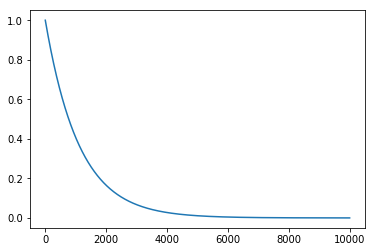

In [7]:
plt.plot(time, epsilon)
plt.show()

In [6]:
for i in range (0,5):
    print(i)

0
1
2
3
4
